# **Teoria Moderna de Portfolio** 

## **Importando Bibliotecas**

In [43]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import seaborn as sn
from math import sqrt
from pandas_datareader import data as dt
import scipy
from scipy.optimize import minimize
import datetime
import cvxopt as co
from cvxopt.blas import dot
from cvxopt.solvers import qp
from cvxopt import blas, solvers

## **Base de Dados**

Para a construção da base de dados são usados os preços de fechamento das 82 ações que compõem o índide BOVESPA, no período de 01 de Janeiro de 2018 até 01 de Julho de 2021. Os dados são obtidos no Yahoo Finance.

In [2]:
# Definindo o dataframe de dados de preço de ativos do portfólio:
precos = pd.DataFrame()

# Definindo o período a ser utilizado
inicio = datetime.datetime(2018, 1, 1)
final = datetime.datetime(2021, 7, 1)

# Definindo os ativos a serem utilizados (Indice BOVESPA):
acoes = ["ABEV3.SA" , "AZUL4.SA" , "B3SA3.SA" , "BBAS3.SA" , "BBDC3.SA",  "BBDC4.SA" , "BBSE3.SA" , "BEEF3.SA", 
"BPAC11.SA", "BRAP4.SA" , "BRDT3.SA" , "BRFS3.SA" , "BRKM5.SA" , "BRML3.SA" , "CCRO3.SA" , "CIEL3.SA" ,
"CMIG4.SA"  ,"COGN3.SA" , "CPFE3.SA" , "CPLE6.SA" , "CRFB3.SA" , "CSAN3.SA" , "CSNA3.SA" , "CVCB3.SA" , "CYRE3.SA" ,
"ECOR3.SA"  ,"EGIE3.SA" , "ELET3.SA" , "ELET6.SA", "EMBR3.SA" , "ENBR3.SA" , "ENEV3.SA" , "ENGI11.SA", "EQTL3.SA" ,
"EZTC3.SA"  ,"FLRY3.SA" , "GGBR4.SA" , "GNDI3.SA" , "GOAU4.SA" , "GOLL4.SA" , "HAPV3.SA" , "HGTX3.SA" , "HYPE3.SA" ,
"IGTA3.SA"  ,"IRBR3.SA" , "ITSA4.SA" , "ITUB4.SA" , "JBSS3.SA" , "JHSF3.SA" , "KLBN11.SA", "LAME4.SA" , "LCAM3.SA" ,
"LREN3.SA"  ,"MGLU3.SA" , "MRFG3.SA" , "MRVE3.SA" , "MULT3.SA" , "NTCO3.SA" , "PCAR3.SA" , "PETR3.SA" , "PETR4.SA" ,
"PRIO3.SA"  ,"QUAL3.SA" , "RADL3.SA" , "RAIL3.SA" , "RENT3.SA" , "SANB11.SA", "SBSP3.SA" , "SULA11.SA", "SUZB3.SA" ,
"TAEE11.SA" , "TOTS3.SA" , "UGPA3.SA" , "USIM5.SA" , "VALE3.SA" , "VIVT3.SA" ,  "WEGE3.SA" ,"YDUQ3.SA"]


for i in acoes:
    precos[i] = dt.get_data_yahoo(i, start = inicio, end = final)['Close']
    
precos.dropna(inplace=True)

## **Simulação dos Portfólios** 

Primeiro calculamos o retorno de cada ação utilizando o preço de fechamento e em seguida calcumos a média dos retornos;


In [4]:
df = precos
retornos = df.pct_change() 
media_retornos = retornos.mean()
sigma = retornos.cov()


**Matriz de Correlação**

In [5]:
corrMatrix = retornos.corr()
corrMatrix

,ABEV3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BPAC11.SA,BRAP4.SA,...,SULA11.SA,SUZB3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,1.000000,0.537507,0.477605,0.588408,0.637129,0.613601,0.506535,0.283998,0.471915,0.390067,...,0.472278,0.229478,0.404927,0.391192,0.589876,0.423451,0.389764,0.435710,0.461766,0.510082
AZUL4.SA,0.537507,1.000000,0.563411,0.672572,0.644643,0.647188,0.457207,0.300036,0.601860,0.412199,...,0.615202,0.185732,0.395505,0.503076,0.619150,0.529052,0.455657,0.356443,0.478523,0.569100
B3SA3.SA,0.477605,0.563411,1.000000,0.683790,0.668858,0.624915,0.601006,0.330473,0.690915,0.506135,...,0.620480,0.160328,0.445507,0.614537,0.648165,0.506838,0.539126,0.429692,0.552695,0.502937
BBAS3.SA,0.588408,0.672572,0.683790,1.000000,0.915418,0.893469,0.674647,0.283831,0.704049,0.520518,...,0.621504,0.103039,0.464360,0.529753,0.720443,0.596966,0.566998,0.422006,0.403218,0.554708
BBDC3.SA,0.637129,0.644643,0.668858,0.915418,1.000000,0.962394,0.684497,0.273679,0.697175,0.555442,...,0.588704,0.100258,0.448385,0.473557,0.707951,0.562805,0.582037,0.464138,0.388540,0.540461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USIM5.SA,0.423451,0.529052,0.506838,0.596966,0.562805,0.538849,0.440197,0.280260,0.512763,0.621403,...,0.475557,0.287037,0.283596,0.442728,0.543676,1.000000,0.645780,0.258014,0.375901,0.426200
VALE3.SA,0.389764,0.455657,0.539126,0.566998,0.582037,0.556074,0.438425,0.390161,0.515290,0.914648,...,0.456147,0.345146,0.295422,0.426369,0.566666,0.645780,1.000000,0.365467,0.356059,0.333842
VIVT3.SA,0.435710,0.356443,0.429692,0.422006,0.464138,0.436481,0.383389,0.285873,0.423089,0.360701,...,0.356062,0.190309,0.427090,0.342843,0.522142,0.258014,0.365467,1.000000,0.290930,0.338906
WEGE3.SA,0.461766,0.478523,0.552695,0.403218,0.388540,0.346661,0.384656,0.385711,0.439606,0.384632,...,0.532994,0.288648,0.362567,0.546098,0.450568,0.375901,0.356059,0.290930,1.000000,0.411007


**Definindo a Taxa Livre de Risco**

In [6]:
taxa_livre_risco = ((1 + 0.0575)**(1/252))-1 
taxa_livre_risco

0.00022188029408676258

**Número do Portfólio**

Para cada portfolio nós definimos um índice

In [7]:
# Número de portfolios a serem simulados
num_portfolio = 10000


peso = np.zeros((num_portfolio,len(precos.columns)))
retorno_esperado = np.zeros((num_portfolio))
vol_esperada = np.zeros((num_portfolio))
sharpeRatio = np.zeros((num_portfolio))

for k in range(num_portfolio):
    w = np.array(np.random.random(len(precos.columns)))
    w = w/np.sum(w)
    peso[k,:] = w
    retorno_esperado[k] = np.mean(media_retornos@w) # Retorno esperado multiplicado pelo peso 
    vol_esperada[k] = np.sqrt(w@sigma@w) # Para a volatilidade esperada usamos a matriz transporta dos pesos e multiplicamos
    sharpeRatio[k] = np.sqrt(252)*(retorno_esperado[k]-taxa_livre_risco)/vol_esperada[k]
    
    

In [8]:
index = np.where(sharpeRatio == sharpeRatio.max())

In [9]:
peso[index,:]

array([[[0.02284642, 0.01188381, 0.01323082, 0.01178492, 0.00244269,
         0.02110538, 0.01483641, 0.00769541, 0.02357031, 0.00883413,
         0.0049264 , 0.0102319 , 0.02397668, 0.00078097, 0.01125444,
         0.00061346, 0.00197087, 0.00413451, 0.02082915, 0.01993084,
         0.01727217, 0.01463926, 0.01611258, 0.00923318, 0.00281039,
         0.00838124, 0.01915012, 0.02117702, 0.00945326, 0.01608838,
         0.01347403, 0.01938656, 0.00210222, 0.02480892, 0.01938558,
         0.00124865, 0.01262568, 0.02099453, 0.02499483, 0.00894533,
         0.02548975, 0.01020646, 0.02166902, 0.01999172, 0.00397284,
         0.01132239, 0.01388419, 0.00188901, 0.02145027, 0.02586585,
         0.00775571, 0.00789692, 0.00232092, 0.01335839, 0.01473385,
         0.01238087, 0.00534425, 0.0056517 , 0.00398023, 0.01711261,
         0.00199295, 0.02397871, 0.0022132 , 0.02327512, 0.01258452,
         0.01015888, 0.01312588, 0.00874177, 0.01607793, 0.02304251,
         0.01407415, 0.00469206, 0

## **Plot dos Portfólios Simulados**

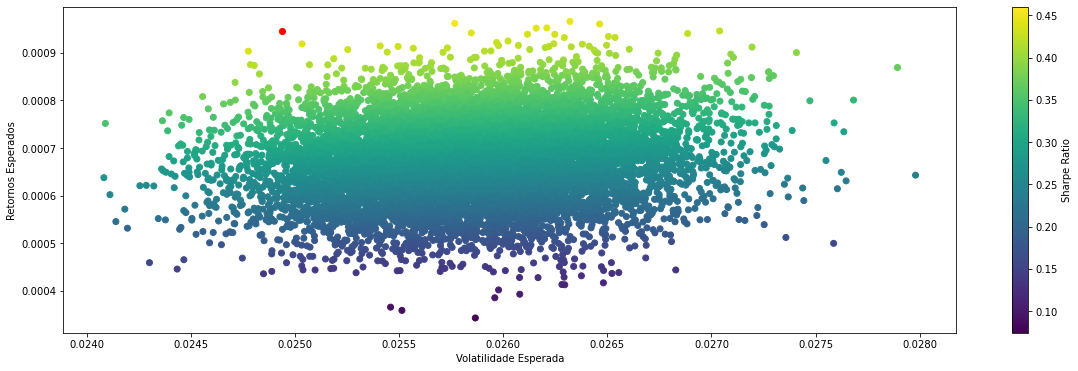

In [10]:
plt.figure(figsize=(20,6))
plt.scatter(vol_esperada,retorno_esperado,c=sharpeRatio)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatilidade Esperada')
plt.ylabel('Retornos Esperados')
plt.scatter(vol_esperada[index],retorno_esperado[index], c = 'red')
plt.show()

## **LAC**

In [21]:
#Inclinação da lac: 

inclinacao_lac = (retorno_esperado[index]-taxa_livre_risco)/vol_esperada[index]

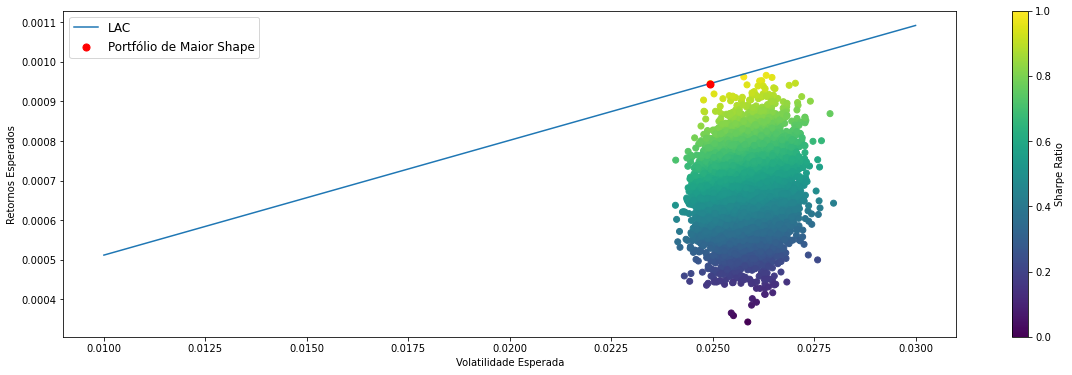

In [25]:
plt.figure(figsize=(20,6))
plt.scatter(vol_esperada,retorno_esperado,c=sharpeRatio)
plt.scatter(vol_esperada[index],retorno_esperado[index],label="Portfólio de Maior Shape",c="red",s=50,zorder=2)
plt.plot(np.array([0.01,0.03]),np.array([0.01,0.03])*inclinacao_lac+taxa_livre_risco, label="LAC",zorder=1)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatilidade Esperada')
plt.ylabel('Retornos Esperados')
plt.scatter(vol_esperada[index],retorno_esperado[index], c = 'red')
plt.legend(loc="upper left",fontsize=12)
plt.show()

## **Fronteira de Otimização**

In [65]:
n_ativos = sigma.shape[0]


p = co.matrix(sigma.values)
q = co.matrix(np.zeros(n_ativos))
g = co.matrix(-np.eye(n_ativos))
h = co.matrix(np.zeros(n_ativos))

a = np.ones((2,n_ativos))
a[0,:] = media_retornos.values
a = co.matrix(a)
retorno_max = np.max(media_retornos)
retorno_min = np.min(media_retornos)

npoints = 100
retornos_range = np.linspace(retorno_min,retorno_max,npoints)

vol_range = np.zeros(npoints)

for pos,ret_i in enumerate(retornos_range):
    break 
    b = co.matrix([ret_i, 1])
    co.solvers.qp(P = p, q = q, A = a, b = b, G = g, h = h)


In [85]:
b = co.matrix([ret_i, 1])

res = co.solvers.qp(P = p, q = q, A = a, b = b, G = g, h = h)

np.array(res['x'])


     pcost       dcost       gap    pres   dres
 0:  4.2041e-04 -9.9943e-01  1e+02  1e+01  1e+01
 1:  4.3675e-04 -7.7169e-01  1e+01  9e-01  9e-01
 2:  6.2009e-04 -6.5562e-03  5e+00  4e-01  4e-01
 3:  1.5687e-03 -2.1790e-02  4e-01  3e-02  3e-02
 4:  1.5833e-03  1.3497e-03  4e-03  3e-04  3e-04
 5:  1.5834e-03  1.5811e-03  4e-05  3e-06  3e-06
 6:  1.5834e-03  1.5834e-03  4e-07  3e-08  3e-08
 7:  1.5834e-03  1.5834e-03  4e-09  3e-10  3e-10
Optimal solution found.


array([[ 4.46773856e-12],
       [ 4.72508438e-13],
       [ 3.25956547e-12],
       [ 3.03619360e-12],
       [ 4.63160453e-12],
       [ 4.64837467e-12],
       [-1.49358460e-12],
       [ 4.55405365e-12],
       [-3.96522289e-12],
       [-4.49753705e-12],
       [ 3.25672981e-12],
       [ 4.55871541e-12],
       [-7.41844551e-12],
       [ 1.82334002e-12],
       [ 4.65222923e-12],
       [-1.49830262e-11],
       [ 3.20964023e-12],
       [-1.98661851e-11],
       [ 4.36523739e-12],
       [ 4.33745241e-12],
       [ 4.37523980e-12],
       [-5.59656356e-13],
       [-9.82573329e-12],
       [ 3.13624528e-12],
       [ 4.07684034e-12],
       [ 4.57288487e-12],
       [ 4.18348179e-12],
       [-5.90316721e-13],
       [ 8.38199069e-13],
       [ 1.63856490e-12],
       [ 4.61755591e-12],
       [-2.28559217e-12],
       [ 4.52504644e-12],
       [ 3.18610849e-12],
       [ 4.11035673e-12],
       [ 4.62631075e-12],
       [-3.15583369e-12],
       [-3.48519272e-13],
       [-3.2

In [86]:

x = np.ones((376, 1))
x[0,:] = 1
x = co.matrix(x)

S = co.matrix(np.cov(retornos))
pbar = co.matrix(np.mean(retornos, axis=1))


In [89]:
retornos = [(pbar, x) for x in res]
riscos = [np.sqrt((x, S * x)) for x in res]

TypeError: can't multiply sequence by non-int of type 'cvxopt.base.matrix'

In [83]:
pbar

<376x1 matrix, tc='d'>

In [47]:

xopt = np.array(res['x'])

fopt = np.array(res['primal objective'])

normal_factor = sum(xopt)

xopt_scaled = np.asarray(xopt) * (1/normal_factor)

In [69]:
pbar

<376x1 matrix, tc='d'>

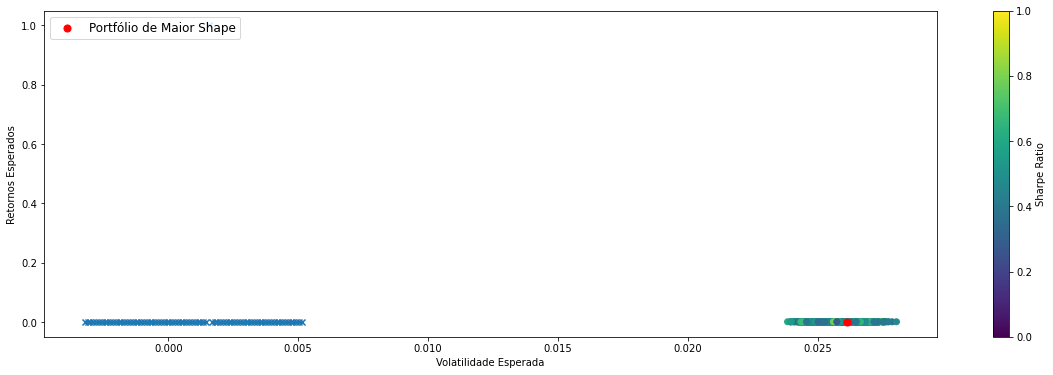

In [327]:
plt.figure(figsize=(20,6))
plt.scatter(vol_esperada,retorno_esperado,c=sharpeRatio)
plt.scatter(vol_esperada[index],retorno_esperado[index],label="Portfólio de Maior Shape",c="red",s=50,zorder=2)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatilidade Esperada')
plt.ylabel('Retornos Esperados')
plt.scatter(vol_esperada[index],retorno_esperado[index], c = 'red')
plt.legend(loc="upper left",fontsize=12)
plt.scatter(, marker = 'x')
plt.show()


In [38]:
ativos = pd.DataFrame({'Ativos':["ABEV3.SA" , "AZUL4.SA" , "B3SA3.SA" , "BBAS3.SA" , "BBDC3.SA",  "BBDC4.SA" , "BBSE3.SA" , "BEEF3.SA", 
"BPAC11.SA", "BRAP4.SA" , "BRDT3.SA" , "BRFS3.SA" , "BRKM5.SA" , "BRML3.SA" , "CCRO3.SA" , "CIEL3.SA" ,
"CMIG4.SA"  ,"COGN3.SA" , "CPFE3.SA" , "CPLE6.SA" , "CRFB3.SA" , "CSAN3.SA" , "CSNA3.SA" , "CVCB3.SA" , "CYRE3.SA" ,
"ECOR3.SA"  ,"EGIE3.SA" , "ELET3.SA" , "ELET6.SA", "EMBR3.SA" , "ENBR3.SA" , "ENEV3.SA" , "ENGI11.SA", "EQTL3.SA" ,
"EZTC3.SA"  ,"FLRY3.SA" , "GGBR4.SA" , "GNDI3.SA" , "GOAU4.SA" , "GOLL4.SA" , "HAPV3.SA" , "HGTX3.SA" , "HYPE3.SA" ,
"IGTA3.SA"  ,"IRBR3.SA" , "ITSA4.SA" , "ITUB4.SA" , "JBSS3.SA" , "JHSF3.SA" , "KLBN11.SA", "LAME4.SA" , "LCAM3.SA" ,
"LREN3.SA"  ,"MGLU3.SA" , "MRFG3.SA" , "MRVE3.SA" , "MULT3.SA" , "NTCO3.SA" , "PCAR3.SA" , "PETR3.SA" , "PETR4.SA" ,
"PRIO3.SA"  ,"QUAL3.SA" , "RADL3.SA" , "RAIL3.SA" , "RENT3.SA" , "SANB11.SA", "SBSP3.SA" , "SULA11.SA", "SUZB3.SA" ,
"TAEE11.SA" , "TOTS3.SA" , "UGPA3.SA" , "USIM5.SA" , "VALE3.SA" , "VIVT3.SA" ,  "WEGE3.SA" ,"YDUQ3.SA"], 'Peso otimo':.x})

SyntaxError: invalid syntax (<ipython-input-38-a342d7b0764e>, line 9)

In [63]:
n_ativos = df.nlargest(10, 'Peso otimo')


KeyError: 'Peso otimo'

In [62]:
df.sort_values(by = 'Peso otimo', ascending = False)

KeyError: 'Peso otimo'

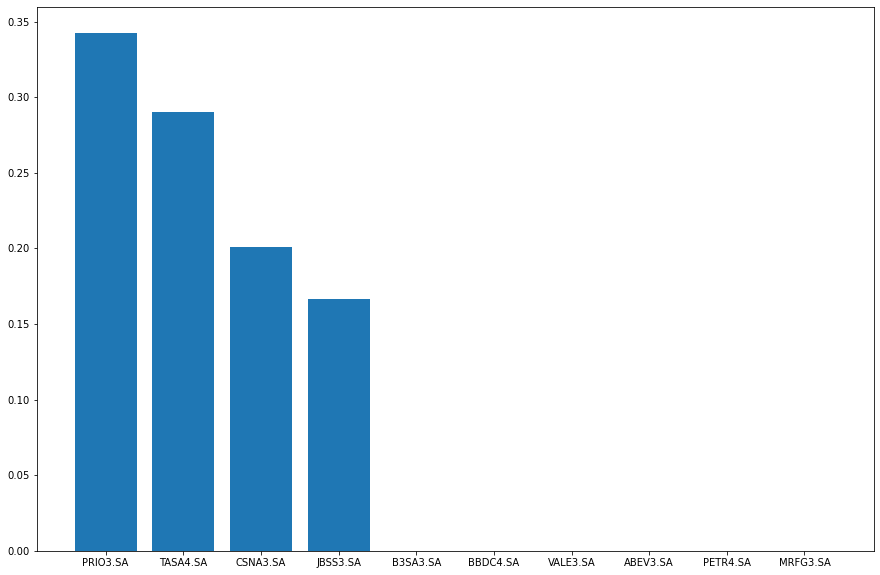

In [22]:
x_pos = np.arange(len(ndf["Ativos"]))

plt.figure(figsize=(15,10))

plt.bar(ndf["Ativos"],ndf['Peso otimo'])

# Adicionando o ticker dos ativos
plt.xticks(x_pos, ndf["Ativos"])

# Mostrar gráfico
plt.show()

### antigo

In [17]:
retornos = np.linspace(min(media_retornos),max(media_retornos),2000)
volatilidade_opt = []
opt = []

def minimizevol(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    return V
def getreturn(w):
    w = np.array(w)
    R = np.sum(media_retornos*w)
    return R
for R in retornos:
    constraints = ({'type':'eq','fun':checksumtoone},
                  {"type":'eq','fun': lambda w: getreturn(w) - R})
    opt = minimize(minimizevol,w0,method = 'SLSQP',bounds = bounds, constraints = constraints)
    volatilidade_opt.append(opt['fun'])

KeyboardInterrupt: 

In [14]:

def negativeSR(w):
    w = np.array(w) # Peso
    R = np.sum(media_retornos*w) # Retorno total do portfólio
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w))) # Volatilidade do portfólio
    SR = (R-taxa_livre_risco)/V # Sharpe Ratio
    return -1*SR

def checksumtoone(w):
    return np.sum(w)-1
w0 = np.full((len(precos.columns)), 1/len(precos.columns)) # Chute pesos (tudo igual)

# Limitando para não ficar short (pesos entre 0 e 1)
a = [(0,1)]
for i in range (2,(len(precos.columns))+1):
    a.append((0,1))
a = tuple(a) 

bounds = (a)
constraints = ({'type':'eq','fun':checksumtoone})
w_opt = minimize(negativeSR,w0,method = 'SLSQP',bounds = bounds, constraints = constraints)
w_opt

     fun: -0.10070536226964567
     jac: array([ 0.04121602,  0.08081739,  0.04334799,  0.08580248,  0.06516732,
        0.062889  ,  0.06443128,  0.05697392,  0.01035873, -0.00445358,
        0.04499137,  0.05708553, -0.00472507,  0.08704895,  0.07058316,
        0.11184011,  0.04085284,  0.12935075,  0.05054485,  0.04948959,
        0.02935872,  0.02005429, -0.0069567 ,  0.07710351,  0.07595002,
        0.070363  ,  0.04347987,  0.03059908,  0.03121331,  0.04657645,
        0.04239113, -0.00156874,  0.04291114,  0.02351652,  0.08363186,
        0.04652532,  0.02902898,  0.02631527,  0.03080953,  0.09488502,
        0.02689953,  0.03514554,  0.03943664,  0.0592717 ,  0.15917448,
        0.05379086,  0.05246602,  0.0318239 ,  0.03668171,  0.00365691,
        0.06098318,  0.03457326,  0.05914604,  0.00558641, -0.00387308,
        0.06666667,  0.06317705,  0.01190551, -0.00705372,  0.07002638,
        0.06627263, -0.00689511,  0.06240443,  0.00979836,  0.06388605,
        0.02756887,  0.

In [15]:
w_opt.x

array([0.00000000e+00, 0.00000000e+00, 6.60951172e-17, 0.00000000e+00,
       1.69484031e-16, 6.68266953e-17, 2.65436919e-17, 3.03407265e-17,
       5.53658829e-17, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.51329166e-17, 5.55822957e-17, 1.85679635e-18,
       4.56142116e-17, 4.86203565e-17, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.84845122e-17, 3.65871045e-01, 0.00000000e+00,
       0.00000000e+00, 5.35376607e-17, 0.00000000e+00, 0.00000000e+00,
       6.11999565e-18, 3.35184422e-17, 0.00000000e+00, 2.27968100e-16,
       4.81422066e-17, 2.92851864e-18, 0.00000000e+00, 8.41502793e-18,
       7.84115285e-17, 0.00000000e+00, 5.62299621e-17, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.04647069e-17,
       9.62450220e-17, 0.00000000e+00, 0.00000000e+00, 3.94867207e-17,
       0.00000000e+00, 3.21877201e-17, 3.63218173e-17, 2.96264395e-17,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.92859512e-18,
      

In [ ]:
opt